# Image processing
## A crash course with `scipy.ndimage` and `scikit-image`

In [18]:
import skimage.io as io

template_str = '{:>15s} : {}'

print('{0} Available plugins {0}'.format(5 * '-'))
plugins = io.find_available_plugins()
for item in plugins:
    print(template_str.format(item, plugins[item]))

print('\n{0} Loaded plugins {0}'.format(5 * '-'))
plugins = io.find_available_plugins(loaded=True)
for item in plugins:
    print(template_str.format(item, plugins[item]))

----- Available plugins -----
            gtk : ['imshow']
           fits : ['imread', 'imread_collection']
        imageio : ['imread', 'imsave', 'imread_collection']
            pil : ['imread', 'imsave', 'imread_collection']
      simpleitk : ['imread', 'imsave', 'imread_collection']
     matplotlib : ['imshow', 'imread', 'imshow_collection', 'imread_collection']
             qt : ['imshow', 'imsave', 'imread', 'imread_collection']
       tifffile : ['imread', 'imsave', 'imread_collection']
           gdal : ['imread', 'imread_collection']
         imread : ['imread', 'imsave', 'imread_collection']

----- Loaded plugins -----
            pil : ['imread', 'imsave', 'imread_collection']
     matplotlib : ['imshow', 'imread', 'imshow_collection', 'imread_collection']


## `io` with python imaging library (pil/pillow)

The [pillow](https://pillow.readthedocs.io/en/5.3.x/handbook) package---a fork of python imaging library (pil)---is a collection of modules to read/write a wide range of different imaging formats. In addition, it leverages on libraries installed on the system for image processing.

In [26]:
from PIL import Image
import requests  # for url-based image loading
from io import BytesIO

format_string = '{:>10s} : {}'
attrbs = ['format', 'size', 'mode']

In [31]:
with Image.open('./extra/Sage_pollen.jpg') as img:
    for attr in attrbs:
        print(format_string.format(attr, getattr(img, attr)))

    format : JPEG
      size : (2560, 1920)
      mode : RGB


In [28]:
response = requests.get('https://upload.wikimedia.org/wikipedia/commons/f/f8/Sage_pollen.jpg')
with Image.open(BytesIO(response.content)) as img:
    for attr in attrbs:
        print(format_string.format(attr, getattr(img, attr)))

    format : JPEG
      size : (2560, 1920)
      mode : RGB


#### Exercice: Scan through a directory to search for image files

Scan through a directory in search of image files. For each image file show the attributes `format`, `size`, and `mode`. Allow to run the script from the command line with an optional argument that indicates the path, the default being the current directory.

__HINT__ : 
* When running from the command line the `argparse` standard library (argparse [tutorial](https://docs.python.org/3/howto/argparse.html?highlight=argparse)) may come in handy.
* For operations on paths the module `path` from the standard library `os` should be considered, make sure the code is not platform dependent!

## some operations on images with the `pillow` package

We will get two `boxes` in the image, do an operation on these subimages, and reinsert them in the original image. For available operations, have a look at [ImageFilter](https://pillow.readthedocs.io/en/5.3.x/reference/ImageFilter.html)

In [1]:
from PIL import Image, ImageFilter

box1 = (250, 250, 450, 450)
box2 = (650, 650, 1050, 1050)
with Image.open('./images/Sage_pollen.jpg') as img:
    region1 = img.crop(box1)
    region1 = region1.transpose(Image.ROTATE_180)
    img.paste(region1, box1)
    
    region2 = img.crop(box2)
    region2 = region2.filter(ImageFilter.MedianFilter(11))
    region2 = region2.filter(ImageFilter.CONTOUR)
    # img.save('./extra/Sage_pollen_EDGE_ENCHANCE.jpg')
    img.paste(region2, box2)
    img.show()

## displaying the image in the notebook

PIL is suited for operations on images, but should not be used to render the images (except for testing purposes).
We propose two alternative options: `matplotlib` and `plotly`.

Be careful about units : we have pixels (websites), dpi (printers & websites), and metric size (printers). Specifying two out of three of these values automatically fixes the third one.

In [5]:
from PIL import Image
import plotly.offline as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

with Image.open('./images/Sage_pollen.jpg') as img:
    img_width, img_height = img.size
    # alternatively use pillow's Image.resize, see https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

scale_factor = 400 / max(img_width, img_height)

layout = go.Layout(
    xaxis = go.layout.XAxis(
        visible = False,
        range = [0, img_width*scale_factor]),
    yaxis = go.layout.YAxis(
        visible=False,
        range = [0, img_height*scale_factor],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor = 'x'),
    width = img_width*scale_factor,
    height = img_height*scale_factor,
    margin = {'l': 0, 'r': 0, 't': 0, 'b': 0},
    images = [go.layout.Image(
        x=0,
        sizex=img_width*scale_factor,
        y=img_height*scale_factor,
        sizey=img_height*scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source='./images/Sage_pollen.jpg')]
)
# we add a scatter trace with data points in opposite corners to give the Autoscale feature a reference point
fig = go.Figure(data=[{
    'x': [0, img_width*scale_factor], 
    'y': [0, img_height*scale_factor], 
    'mode': 'markers',
    'marker': {'opacity': 0}}],layout = layout)
py.iplot(fig, filename='EXAMPLES/zoom_Pollen')

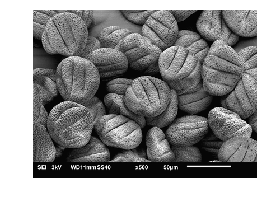

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

%matplotlib inline

with Image.open('./images/Sage_pollen.jpg') as img:
    img_width, img_height = img.size
    scale_factor = 400 / max(img_width, img_height)
    im_width = round(scale_factor * img_width)
    im_height = round(scale_factor * img_height)
    im = img.resize((im_width, im_height), Image.LANCZOS)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im)
ax.set_axis_off()  # equivalent to the following two lines of code
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
ax.autoscale(False)

#### Exercice
Create a function that allows to focus on a circle centered at specified coordinates $(x,y)$ and with radius $r$. The rest of the image will be black or transparent.